In [61]:
# Loading in all relevant packages
# ----------------------------------------------------------------------------
import cosmopower as cp
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------------------------------------------

# Calling the trained models

We use cosmopower to load in the models contained in "/training/trained_models"

In [24]:
NN_directory = './training/trained_models/'

# Loading in models
cp_pkmm_lin = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'pkmm_lin_model')
cp_pkmm_nonlin = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'pkmm_nonlin_model')
cp_bias_sq = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'bias_sq_model')
cp_eta = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'eta_model')
cp_mu = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'mu_model')
cp_chiz = cp.cosmopower_NN(restore=True, restore_filename=NN_directory+'chiz_model')

NN_models = {'pkmm_lin': cp_pkmm_lin, 'pkmm_nonlin':cp_pkmm_nonlin,'bias_sq':cp_bias_sq,
           'eta':cp_eta, 'mu':cp_mu, 'chiz':cp_chiz}

# Getting the output modes (wavevector k or redshift z) of the models
k_vec = cp_pkmm_lin.modes
z_vec = cp_chiz.modes
print("Wave dependent functions are emulated for k in the range of", min(k_vec), "to", max(k_vec), "1/Mpc")
print("Comoving distance is emulated for z in the range of", min(z_vec), "to", max(z_vec))
print('-----------------------------------')
# The cosmological functions can be predicted for the following parameters
print("Possible inputs for the cosmological functions are:")
print(cp_pkmm_nonlin.parameters)
print('-----------------------------------')

Wave dependent functions are emulated for k in the range of 1e-05 to 150.0 1/Mpc
Comoving distance is emulated for z in the range of 0.001 to 4.5
-----------------------------------
Possible inputs for the cosmological functions are:
ListWrapper(['Omega_b', 'Omega_cdm', 'h', 'n_s', 'm_nu', 'log10_T_heat', 'sigma8', 'alpha_B', 'alpha_M', 'log10_k_screen', 'z_val'])
-----------------------------------


We call now the wavenumber dependent functions with a given input cosmology. Note that the power spectra and electron bias have been trained on their log10-values.

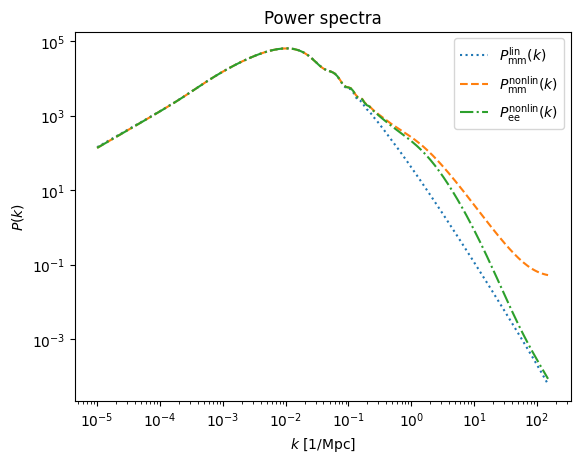

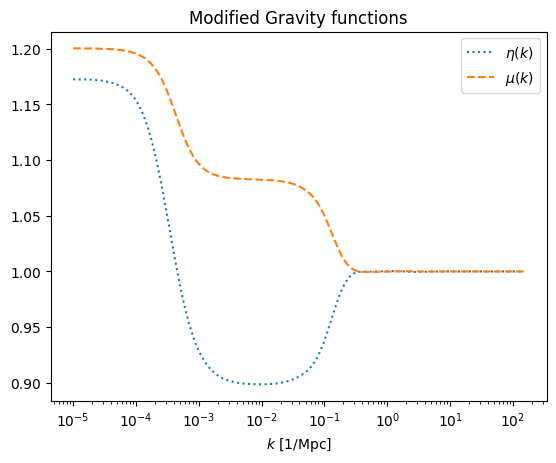

In [58]:
# Input parameters
input_dict={
    'Omega_b': [0.08],
    'Omega_cdm': [0.24],
    'h': [0.7],
    'n_s': [0.96],
    'm_nu': [0.12],   # in eV
    'log10_T_heat': [7.5],
    'sigma8': [0.8],
    'alpha_B': [1.3],
    'alpha_M': [0.5],
    'log10_k_screen': [-1.],
    'z_val': [0.5]
}

# Predicting the cosmological functions
predict_pkmm_lin = cp_pkmm_lin.ten_to_predictions_np(input_dict)
predict_pkmm_nonlin = cp_pkmm_nonlin.ten_to_predictions_np(input_dict)
predict_bias_sq = cp_bias_sq.ten_to_predictions_np(input_dict)
predict_eta = cp_eta.predictions_np(input_dict)
predict_mu = cp_mu.predictions_np(input_dict)

plt.loglog(k_vec, predict_pkmm_lin[0], label=r'$P_{\rm mm}^{\rm lin}(k)$', linestyle=':')
plt.loglog(k_vec, predict_pkmm_nonlin[0], label=r'$P_{\rm mm}^{\rm nonlin}(k)$', linestyle='--')
plt.loglog(k_vec, predict_pkmm_nonlin[0]*predict_bias_sq[0], label=r'$P_{\rm ee}^{\rm nonlin}(k)$', linestyle='-.')
plt.xlabel(r'$k$ [1/Mpc]')
plt.ylabel(r'$P(k)$')
plt.title('Power spectra')
plt.legend()
plt.show()
plt.close()

plt.semilogx(k_vec, predict_eta[0], label=r'$\eta(k)$', linestyle=':')
plt.semilogx(k_vec, predict_mu[0], label=r'$\mu(k)$', linestyle='--')
plt.xlabel(r'$k$ [1/Mpc]')
plt.title('Modified Gravity functions')
plt.legend()
plt.show()
plt.close()

# Angular power spectrum calculation
To provide an example of the code in action, we define the angular power spectrum code used for the MCMC below

In [69]:
# Angular power spectrum class
# ----------------------------------------
import numpy as np
from time import time
from scipy.integrate import trapz
from scipy.interpolate import interp1d, RectBivariateSpline
from copy import deepcopy
from astropy import constants as const
from astropy import units as u
from glob import glob

class cosmology_results:
    def __init__(self,
                NN_params,           # dictionary of lists of all NN parameters except z
                alpha,               # depth of FRB survey
                N_FRB,               # total number of observed FRBs
                f_sky_frb,           # FRB survey footprint
                FRB_bin_num,         # number of FRB tomographic redshift bins
                lensing_survey,      # must be 'kids' or 'euclid'
                f_sky_lens,          # lensing footprint
                l_array,             # 3 entry array with [l_start, l_end, l_num]
                redshift_array,      # 3 entry array with [z_start, z_end, z_num]
                NN_models,           # dictionary of loaded cosmopower models
                ):

        self.f_sky_frb = f_sky_frb
        self.f_sky_lens = f_sky_lens
        self.FRB_bin_num = FRB_bin_num
        if lensing_survey == 'kids':
            self.lens_z_dir = './photoz/kids_photoz'
        elif lensing_survey == 'euclid':
            self.lens_z_dir = './photoz/euclid_photoz'
        else:
            print('Lensing survey not found: Specify "kids" or "euclid" as lensing survey.')
        self.lensing_survey = lensing_survey
        self.lens_bin_num = len(glob(self.lens_z_dir + '/*'))
        self.alpha = alpha
        self.N_FRB = N_FRB
        self.n_bar = N_FRB/4/np.pi/self.f_sky_frb   # number of FRB per solid angle
        self.params = deepcopy(NN_params)
        self.models = NN_models

        # Extracting redshift array and extending input dictionary to z_len
        self.z_start = redshift_array[0]
        self.z_end = redshift_array[1]
        self.z_num = redshift_array[2]
        self.z_arr = np.geomspace(self.z_start, self.z_end, self.z_num)

        self.z_for_chiz = np.geomspace(1e-3,4.5,200)
        for name in self.params.keys():
            self.params[name] = self.params[name]*np.ones(self.z_num)
        self.params['z_val'] = self.z_arr

        # Defining k_arr
        self.k_arr = np.geomspace(1e-5,150,200)

        # Extracting l array
        self.l_start = l_array[0]
        self.l_end = l_array[1]
        self.l_num = l_array[2]
        # Defining a logspaced l array, but since l must be integers a bunch of corrections are needed
        self.l_arr = np.unique(np.round(np.geomspace(self.l_start, self.l_end, self.l_num))).astype('int')
        self.l_num = len(self.l_arr)

        # calculating functions from trained models
        self.pkmm_lin = (self.models['pkmm_lin'].ten_to_predictions_np(self.params)).T
        self.pkmm_nonlin = (self.models['pkmm_nonlin'].ten_to_predictions_np(self.params)).T
        self.bias_sq = (self.models['bias_sq'].ten_to_predictions_np(self.params)).T
        self.eta = (self.models['eta'].predictions_np(self.params)).T
        self.mu = (self.models['mu'].predictions_np(self.params)).T
        self.chiz = self.models['chiz'].predictions_np(self.params)

        self.Pk_gas_int = RectBivariateSpline(x=self.k_arr, y=self.z_arr, z=(self.pkmm_nonlin*self.bias_sq))
        self.Pk_matter_int = RectBivariateSpline(x=self.k_arr, y=self.z_arr, z=self.pkmm_nonlin)
        self.Pk_gas_matter_int = RectBivariateSpline(x=self.k_arr, y=self.z_arr, z=(self.pkmm_nonlin*np.sqrt(self.bias_sq)))
        self.eta_of_kz_int = RectBivariateSpline(x=self.k_arr, y=self.z_arr, z=self.eta)
        self.mu_of_kz_int = RectBivariateSpline(x=self.k_arr, y=self.z_arr, z=self.mu)
        self.chi_z = interp1d(self.z_for_chiz, self.chiz[0,:])

        # Cosmological constants
        self.h = self.params['h']                                     # Hubble radius in Mpc
        self.H0 = self.h*100 * u.km / u.s / u.Mpc                        # Hubble constant in km/s/Mpc
        self.xH = const.c.to('km/s') / self.H0                           # Hubble radius in Mpc
        self.Onu0 = self.params['m_nu']/(self.h**2*93.14)                # Neutrino density parameter
        self.Om0 = self.params['Omega_b']+self.params['Omega_cdm']+self.Onu0 # Matter density parameter
        self.mp = const.m_p                                             # Proton mass
        self.G = const.G                                                # Gravitational constant

        f_IGM_pre = 0.9  # keep constant for now at redshifts < 1. Can be calculated from https://github.com/FRBs/FRB/blob/main/frb/dm/igm.py as f_diffuse
        f_He = 0.246     # Helium fraction
        f_H = 1. - f_He
        f_e = (f_H + 1/2. * f_He)  # electron fraction
        self.fIGM = f_IGM_pre*f_e
        #self.fIGM = 0.84                                                # electron fraction of the IGM

        self.A = 3 * self.H0 * self.params['Omega_b'][0] * const.c / 8 / np.pi\
                    / self.G / self.mp                                  # FRB weighting function normalization
        self.A = self.A.to(u.pc/u.cm**3)                                # Whatever that dimension is supposed to mean


        # Interpolating FRB density n(z)
        self.n_FRB_argument = self.z_arr**2 * np.exp(-self.alpha * self.z_arr)
        self.n_FRB_normalisation = trapz(self.n_FRB_argument, self.z_arr)
        self.n_FRB_full = self.n_FRB_argument / self.n_FRB_normalisation
        self.n_FRB_int = interp1d(self.z_arr, self.n_FRB_full)

        # Interpolating FRB fluctuation angular power spectrum weighting function W(z)
        self.W_FRB_integrand = [self.n_FRB_int(self.z_arr[i:]) for i in range(self.z_num)]
        self.W_FRB_full = [trapz(self.W_FRB_integrand[i], self.z_arr[i:]) for i in range(self.z_num)] \
                            * (1+self.z_arr) * self.A.value * self.fIGM / self.xH.value
        self.W_FRB_int = interp1d(self.z_arr, self.W_FRB_full, fill_value="extrapolate")


        # Extracting "equipopulated" redshift bin edges
        # ----------------------------------------------------------------
        # Preparing CDF
        self.z_spacing = [self.z_arr[i+1]-self.z_arr[i] for i in range(len(self.z_arr)-1)]
        self.z_spacing.insert(0,0)
        self.n_FRB_CDF = np.cumsum(self.n_FRB_int(self.z_arr)*self.z_spacing)

        # Inverting CDF to get redshift at given population percentage
        self.z_percentile = np.linspace(0, 1, self.FRB_bin_num+1)
        self.n_FRB_PPF_int = interp1d(self.n_FRB_CDF, self.z_arr, fill_value="extrapolate")
        self.tomo_z_bin_edges = self.n_FRB_PPF_int(self.z_percentile)
        self.tomo_z_bin_edges[-1] = self.z_arr[-1]    # Necessary because log messes up boundary after inversion
        self.tomo_z_bin_middle_alt = [(self.tomo_z_bin_edges[i]+self.tomo_z_bin_edges[i+1])/2 \
                                  for i in range(self.FRB_bin_num)]
        self.tomo_z_bin_middle = []
        for i in range(self.FRB_bin_num):
            aux_z = np.linspace(self.tomo_z_bin_edges[i], self.tomo_z_bin_edges[i+1],200)
            integral = trapz(self.n_FRB_int(aux_z)*aux_z,aux_z)
            normalization = trapz(self.n_FRB_int(aux_z),aux_z)
            self.tomo_z_bin_middle.append(integral/normalization)
        self.tomo_z_bin_middle = np.array(self.tomo_z_bin_middle)
        # ----------------------------------------------------------------

    # Importing kids_lensing
    # --------------------------------------------------------------------
    def get_photoz(self):
        filenames = glob(self.lens_z_dir+'/*')
        binnum = len(filenames)
        filenames.sort()

        if self.lensing_survey == 'kids':
            files_raw = np.array([(np.loadtxt(i)).T for i in filenames])
            nofz_norm = 0.05         # Normalisation factor for all redshift bins
            files_int = [interp1d(files_raw[i,0,:], files_raw[i,1,:]/nofz_norm,\
                                  fill_value=0, bounds_error=False) for i in range(binnum)]

        else:
            files_raw = np.array([np.loadtxt(i) for i in filenames])
            files_int = [interp1d(files_raw[i,:,0], files_raw[i,:,1],\
                                  fill_value=0, bounds_error=False) for i in range(binnum)]

        return files_int
    # --------------------------------------------------------------------


    # Lensing Weighting function
    # --------------------------------------------------------------------
    def tomo_z_lens_weighting_func(self):
        prefac = 3/2 / self.xH**2 * self.Om0
        z_num = self.z_num
        chi = self.chi_z(self.z_arr)
        z = self.z_arr
        W_int = []
        lens_nofz = self.get_photoz()

        for i in range(self.lens_bin_num):
            # Here with survey data
            W_integral = [trapz((chi[k:]-chi[k])/chi[k:]*lens_nofz[i](z[k:]), z[k:])\
                            for k in range(z_num)]
            W_normalisation = trapz(lens_nofz[i](z), z)

            W_full = prefac * chi * (1 + self.z_arr) * W_integral / W_normalisation

            W_int.append(interp1d(z, W_full, fill_value="extrapolate"))

        return W_int
    # --------------------------------------------------------------------

    # Calculating tomographic redshift bin weighting function
    # --------------------------------------------------------------------
    def tomo_z_FRB_weighting_func(self):
        z_num = self.z_num
        W_int = []
        for i in range(self.FRB_bin_num):
            z_bin1 = np.geomspace(self.z_start, self.tomo_z_bin_edges[i], z_num)
            z_bin2 = np.geomspace(self.tomo_z_bin_edges[i], self.tomo_z_bin_edges[i+1], z_num)
            z_bin3 = np.geomspace(self.tomo_z_bin_edges[i+1], self.z_end, z_num)

            W_bin1 = self.A.value * self.fIGM / self.xH.value * (1+z_bin1)
            W_bin2_integral = [trapz(self.n_FRB_int(z_bin2[k:]), z_bin2[k:]) for k in range(len(z_bin2))]
            W_bin2_normalisation = trapz(self.n_FRB_int(z_bin2), z_bin2)

            W_bin2 = self.A.value * self.fIGM / self.xH.value * (1+z_bin2) * W_bin2_integral / W_bin2_normalisation
            W_bin3 = np.zeros(len(z_bin3))

            if i == 0:
                z_all = np.hstack((z_bin2, z_bin3))
                W_all = np.hstack((W_bin2, W_bin3))
            else:
                z_all = np.hstack((z_bin1, z_bin2, z_bin3))
                W_all = np.hstack((W_bin1, W_bin2, W_bin3))

            W_int.append(interp1d(z_all, W_all, fill_value="extrapolate"))

        return W_int
    # --------------------------------------------------------------------

    # Calculating tomographic C(l) ...
    # --------------------------------------------------------------------
    # ... without noise
    def tomo_Cl_limber_matrix(self):
        z = self.z_arr[self.z_arr != 0]
        l = self.l_arr
        chi = self.chi_z(z)

        Weight_all_int = np.hstack((self.tomo_z_FRB_weighting_func(), self.tomo_z_lens_weighting_func()))
        Weight_all = np.array([func(z) for func in Weight_all_int])

        Pkz_l_gas = np.array([self.Pk_gas_int((ll+0.5)/chi[::-1], z) for ll in l])
        Pkz_l_matter = np.array([self.Pk_matter_int((ll+0.5)/chi[::-1], z) for ll in l])
        Pkz_l_gas_matter = np.array([self.Pk_gas_matter_int((ll+0.5)/chi[::-1], z) for ll in l])

        Pkz_l_gas = np.diagonal(Pkz_l_gas[:,::-1,:], axis1=1, axis2=2)
        Pkz_l_matter = np.diagonal(Pkz_l_matter[:,::-1,:], axis1=1, axis2=2)
        Pkz_l_gas_matter = np.diagonal(Pkz_l_gas_matter[:,::-1,:], axis1=1, axis2=2)

        Pkz_l_matrix = np.zeros(shape=(self.FRB_bin_num+self.lens_bin_num, \
                                   self.FRB_bin_num+self.lens_bin_num, self.l_num,  len(chi)))
        Pkz_l_matrix[:self.FRB_bin_num, :self.FRB_bin_num] = Pkz_l_gas
        Pkz_l_matrix[self.FRB_bin_num:, self.FRB_bin_num:] = Pkz_l_matter
        Pkz_l_matrix[self.FRB_bin_num:, :self.FRB_bin_num] = Pkz_l_gas_matter
        Pkz_l_matrix[:self.FRB_bin_num, self.FRB_bin_num:] = Pkz_l_gas_matter
        Pkz_l_matrix = np.swapaxes(Pkz_l_matrix, axis1=-1, axis2=-2)

        hiclass_factor = np.array([(1+1/self.eta_of_kz_int((ll+0.5)/chi[::-1], z))*
                                    self.mu_of_kz_int((ll+0.5)/chi[::-1], z) for ll in l])
        hiclass_factor = np.diagonal(hiclass_factor[:,::-1,:], axis1=1, axis2=2)
        hiclass_factor = np.swapaxes(hiclass_factor, axis1=-1, axis2=-2)

        Cl_integrand = Weight_all[:,None,:,None] * Weight_all[None,:,:,None] \
                        / chi[None,None,:,None]**2 * Pkz_l_matrix

        Cl_integrand[self.FRB_bin_num:, self.FRB_bin_num:] *= hiclass_factor**2/4
        Cl_integrand[self.FRB_bin_num:, :self.FRB_bin_num] *= hiclass_factor/2
        Cl_integrand[:self.FRB_bin_num, self.FRB_bin_num:] *= hiclass_factor/2

        Cl_matrix = trapz(y=Cl_integrand, x=chi, axis=-2)

        # Interpolating Cl_matrix
        l_int = np.arange(self.l_start, self.l_end+1, 1)
        Cl_matrix_interpolation = interp1d(l, Cl_matrix, axis=-1, fill_value="extrapolate")
        Cl_matrix_int = Cl_matrix_interpolation(l_int)

        return Cl_matrix_int, l_int

    # ... with shot noise
    def tomo_Cl_limber_matrix_noise(self):
        total_bin = self.FRB_bin_num + self.lens_bin_num
        Cl_matrix, l_arr = self.tomo_Cl_limber_matrix()
        l_num = len(l_arr)

        # FRB Noise from host galaxy (shot noise)
        sigma_FRB_0 = 50 * u.pc / u.cm**3
        sigma_FRB = sigma_FRB_0.value/(1+self.tomo_z_bin_middle)
        n_eff_FRB = self.n_bar/self.FRB_bin_num
        FRB_noise_diag = sigma_FRB**2 / n_eff_FRB

        # Lens Noise from intrinsic ellipticity (also shot noise?)
        if self.lensing_survey == 'kids':
            sigma_ellip = np.asarray([0.27, 0.26, 0.27, 0.25, 0.27])
            n_eff_lens = np.asarray([0.62, 1.18, 1.85, 1.26, 1.31]) * 2 / (u.arcmin**2).to(u.rad**2)
        else:
            sigma_ellip = np.ones(10)*0.3
            n_eff_lens = np.ones(10)*3 * 2 / (u.arcmin**2).to(u.rad**2)
        lens_noise_diag = sigma_ellip**2 / n_eff_lens

        noise_diag = np.hstack((FRB_noise_diag, lens_noise_diag))
        Cl_matrix_noise = Cl_matrix + np.diag(noise_diag)[:,:,None]

        return Cl_matrix_noise, l_arr
    
    # Only calculating noise contribution
    # --------------------------------------------------------------------
    def tomo_Cl_noise_only(self):
        
        total_bin = self.FRB_bin_num + self.lens_bin_num
        
        # FRB Noise from host galaxy (shot noise)
        sigma_FRB_0 = 50 * u.pc / u.cm**3
        sigma_FRB = sigma_FRB_0.value/(1+self.tomo_z_bin_middle)
        n_eff_FRB = self.n_bar/self.FRB_bin_num
        FRB_noise_diag = sigma_FRB**2 / n_eff_FRB
        
        # Lens Noise from intrinsic ellipticity (also shot noise?)
        if self.lensing_survey == 'kids':
            sigma_ellip = np.asarray([0.27, 0.26, 0.27, 0.25, 0.27])
            n_eff_lens = np.asarray([0.62, 1.18, 1.85, 1.26, 1.31]) * 2 / (u.arcmin**2).to(u.rad**2)
        else:
            sigma_ellip = np.ones(10)*0.3
            n_eff_lens = np.ones(10)*3 * 2 / (u.arcmin**2).to(u.rad**2)
        lens_noise_diag = sigma_ellip**2 / n_eff_lens 
        
        noise_diag = np.hstack((FRB_noise_diag, lens_noise_diag))
        
        return noise_diag
    # --------------------------------------------------------------------

    # Calculate SNR for generic Parameter Amplitude Cl = A*theta+B
    # --------------------------------------------------------------------
    def SNR_sq_frb(self):
        covar, l_arr = self.tomo_Cl_limber_matrix_noise()
        data, l_arr = self.tomo_Cl_limber_matrix()

        covar = np.moveaxis(covar[:self.FRB_bin_num, :self.FRB_bin_num, :], -1, 0)
        data = np.moveaxis(data[:self.FRB_bin_num, :self.FRB_bin_num, :], -1, 0)
        covar_inv = np.linalg.inv(covar)
        argument = (data@covar_inv)@(data@covar_inv)
        SNR = (l_arr+0.5)*np.trace(argument, axis1=1, axis2=2)

        return SNR, l_arr

    def SNR_sq_lens(self):
        covar, l_arr = self.tomo_Cl_limber_matrix_noise()
        data, l_arr = self.tomo_Cl_limber_matrix()

        covar = np.moveaxis(covar[self.FRB_bin_num:, self.FRB_bin_num:, :], -1, 0)
        data = np.moveaxis(data[self.FRB_bin_num:, self.FRB_bin_num:, :], -1, 0)
        covar_inv = np.linalg.inv(covar)
        argument = (data@covar_inv)@(data@covar_inv)
        SNR = (l_arr+0.5)*np.trace(argument, axis1=1, axis2=2)

        return SNR, l_arr

    def SNR_sq_cross(self):
        covar, l_arr = self.tomo_Cl_limber_matrix_noise()
        data, l_arr = self.tomo_Cl_limber_matrix()

        covar = np.moveaxis(covar, -1, 0)
        data = np.moveaxis(data, -1, 0)
        covar_inv = np.linalg.inv(covar)
        argument = (data@covar_inv)@(data@covar_inv)
        SNR = (l_arr+0.5)*np.trace(argument, axis1=1, axis2=2)

        return SNR, l_arr
# ---------------------------------------------------------------------------------

And now we run it

In [70]:
# Angular power spectrum calculation
# --------------------------------------------------------------------

# Creating fiducial cosmology dictionary ...
param_name = ['Omega_b', 'Omega_cdm', 'h', 'n_s', 'm_nu', 'log10_T_heat', 'sigma8', 'alpha_B', 'alpha_M', 'log10_k_screen']
param_val_fid = [np.array(0.04931), np.array(0.2642), np.array(0.674), np.array(0.965), np.array(0.06),
                 np.array(7.8), np.array(0.811), np.array(0.05), np.array(0.05), np.array(-1)]
input_dict_fid = dict(zip(param_name, param_val_fid))

# Creating dictionary of survey params ...
alpha = 2.5
N_FRB = 1e4
z_bin_num = 4
lensing_survey = 'euclid'
f_sky_frb = 0.7
if lensing_survey == 'euclid':
    f_sky_lens = 0.3
    l_array = [1,5000,600]
elif lensing_survey == 'kids':
    f_sky_lens = 1/40.
    l_array = [1,2000,600]
else:
    pass
redshift_array = [1e-2,4,151]
survey_dict={'alpha':alpha, 'f_sky_frb':f_sky_frb, 'f_sky_lens':f_sky_lens, 'N_FRB':N_FRB,
             'FRB_bin_num':z_bin_num, 'lensing_survey':lensing_survey, 'l_array':l_array,
             'redshift_array':redshift_array}

# ... and combining them
class_dict_fid = {'NN_params':input_dict_fid, 'alpha':alpha, 'N_FRB': N_FRB, 'FRB_bin_num': z_bin_num, 'f_sky_frb': f_sky_frb, 'f_sky_lens': f_sky_lens,
                  'lensing_survey':lensing_survey, 'l_array':l_array, 'redshift_array':redshift_array, 'NN_models':NN_models}

t1 = time()
cell_class = cosmology_results(**class_dict_fid)
Cl_data_full, l_full = cell_class.tomo_Cl_limber_matrix_noise()
t2 = time()

print('Took me ' + str(np.round(t2-t1)) + ' seconds.')

Took me 2.0 seconds.


## Plotting
We can now make a fancy plot showing the predicted angular power spectrum for the Euclid and FRB auto-correlation, and their cross-correlation

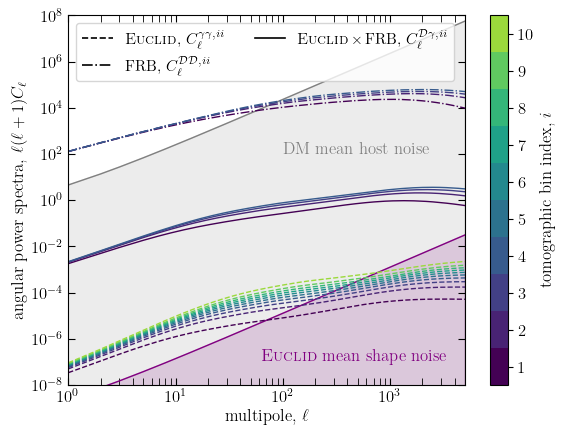

In [73]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 12, 'lines.linewidth': 1.0})

#Plotting Cl

# Calculating Cls for specific survey
# -----------------------------------------------
survey = 'euclid'
if survey=='kids':
    class_dict_fid['lensing_survey'] = 'kids'
    results_kids = cosmology_results(**class_dict_fid)
    Cl_nonoise, l_arr = results_kids.tomo_Cl_limber_matrix()
    Cl_noise, l_arr = results_kids.tomo_Cl_limber_matrix_noise()
    noise = results_kids.tomo_Cl_noise_only()
    noise_frb = np.mean(noise[:4])
    noise_lens = np.mean(noise[4:])
    num_lines = 5
    colors = plt.cm.viridis(np.linspace(0, 0.85, num_lines))
    cmap = ListedColormap([color for color in colors])
    survey_name = r'\textsc{KiDS}'
elif survey=='euclid':
    class_dict_fid['lensing_survey'] = 'euclid'
    results_euclid = cosmology_results(**class_dict_fid)
    Cl_nonoise, l_arr = results_euclid.tomo_Cl_limber_matrix()
    Cl_noise, l_arr = results_euclid.tomo_Cl_limber_matrix_noise()
    noise = results_euclid.tomo_Cl_noise_only()
    noise_frb = np.mean(noise[:4])
    noise_lens = np.mean(noise[4:])
    num_lines = 10
    colors = plt.cm.viridis(np.linspace(0, 0.85, num_lines))
    cmap = ListedColormap([color for color in colors])
    survey_name = r'\textsc{Euclid}'
# -----------------------------------------------

# Plotting Cls 
# -----------------------------------------------
fig, ax = plt.subplots()

ax.loglog(l_arr, l_arr*(l_arr+1)*noise_frb, '-', color='gray')
ax.fill_between(l_arr, l_arr*(l_arr+1)*noise_frb, color='gray', alpha=0.15)
for i in range(4):
    ax.loglog(l_arr, l_arr*(l_arr+1)*Cl_nonoise[i,i,:], '-.', color=colors[i])

ax.loglog(l_arr, l_arr*(l_arr+1)*noise_lens, '-', color='purple')
ax.fill_between(l_arr, l_arr*(l_arr+1)*noise_lens, color='purple', alpha=0.15)
for i in range(num_lines):
    ax.loglog(l_arr, l_arr*(l_arr+1)*Cl_nonoise[i+4,i+4,:], '--', color=colors[i])

for i in range(4):
    ax.loglog(l_arr, l_arr*(l_arr+1)*Cl_nonoise[i,i+4,:], '-', color=colors[i])
# -----------------------------------------------

# Adding colourmap
# -----------------------------------------------
# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap)
sm.set_array([])

# Calculate tick positions to be in the middle of color segments
tick_positions = np.linspace(0, 1, num_lines + 1) + 0.5 / num_lines

# Add a colorbar with middle-aligned tick labels
cbar = plt.colorbar(sm, ax=ax, label=r'tomographic bin index, $i$', ticks=tick_positions)
cbar.set_ticklabels([str(i+1) for i in range(num_lines+1)])
# -----------------------------------------------

# Making a custom legend
# -----------------------------------------------
custom_lines = [Line2D([0], [0], color='k', lw=1.2, linestyle='--'),
                Line2D([0], [0], color='k', lw=1.2, linestyle='-.'),
                Line2D([0], [0], color='k', lw=1.2, linestyle='-')]
custom_handles = [survey_name+r', $C_\ell^{\gamma\gamma,ii}$', 
                  r'FRB, $C_\ell^{\mathcal{D}\mathcal{D},ii}$',
                  survey_name+r'\,$\times$\,FRB, $C_\ell^{\mathcal{D}\mathcal{\gamma},ii}$']
plt.legend(custom_lines, custom_handles, loc='upper left', ncol=2, fontsize=11)
# -----------------------------------------------

# Finishing up plot
# -----------------------------------------------

plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'angular power spectra, $\ell(\ell+1)C_\ell$')
ax.tick_params(which='both', length=5, direction='in', top=True, right=True)
plt.text(x=10**(2.0), y=10**(2), s=r'DM mean host noise', fontdict=None, color='grey')
plt.text(x=10**(1.8), y=10**(-7), s=survey_name+r' mean shape noise', fontdict=None, color='purple')
plt.xlim([l_arr[0],l_arr[-1]])
plt.ylim([1e-8,1e8])
#plt.savefig('./master_thesis_miscalleneous_plots/'+survey+'_cl.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()